# Отбор информативных признаков

Монтируем google-диск

In [1]:
# from google.colab import drive
# drive.mount('/content/gdrive', force_remount = True)

Mounted at /content/gdrive


Устанавливаем недостающие библиотеки

In [ ]:
!pip install category_encoders

Подключаем необходимые библиотеки

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from category_encoders import BinaryEncoder

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Загружаем набор данных

In [4]:
path = "/content/gdrive/MyDrive/ML/Datasets/adult.csv"            # Иногда могут быть проблемы с кирилицей в названиях папок на пути к файлу, постарайтесь всегда использовтаь только латиницу.
data = pd.read_csv(path, sep = ",")                               # Путь к файлу можно записать как отдельно, так и внутри метода read_csv.

In [5]:
data.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,Never-worked,77053,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,Never-worked,186061,Some-college,10,Widowed,Handlers-cleaners,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


In [6]:
y = data["income"]
X = data.drop(["income"], axis = 1)

#Как будем сравнивать?

In [7]:
SEED = 144

logit = LogisticRegression(random_state = SEED)
rf = RandomForestClassifier(random_state = SEED)

In [8]:
object_list_feature = list(X.select_dtypes(include = 'object').columns)    # Создаём список категориальных признаков

In [11]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.8, stratify = y, random_state = SEED)  # разделяем набор данных на тренировачную и тестовую выборку

In [15]:
X_train = X_train.reset_index(drop = True)
y_train = y_train.reset_index(drop = True)
X_val = X_val.reset_index(drop = True)
y_val = y_val.reset_index(drop = True)

In [17]:
def get_score(model, X, y, X_val, y_val):
  model.fit(X, y)
  y_pred = model.predict_proba(X_val)[:,1]
  score = roc_auc_score(y_val, y_pred)
  return score

def label_encoder(X, X_val):
  categorical_feature_list = list(X.select_dtypes(include = 'object').columns)
  encoding_dict = defaultdict(LabelEncoder)

  for col in categorical_feature_list:
    le = LabelEncoder()
    le.fit(list(X[col]))
    encoding_dict[col] = le

  for col in categorical_feature_list:
    X[col] = encoding_dict[col].transform(X[col])
    X_val[col] = encoding_dict[col].transform(X_val[col])

  return(X, X_val)

In [18]:
X_train, X_val = label_encoder(X_train, X_val)

In [19]:
binary_enc = BinaryEncoder(cols = object_list_feature).fit(X_train, y_train)

X_train_binary = binary_enc.transform(X_train.reset_index(drop = True))
X_val_binary = binary_enc.transform(X_val.reset_index(drop = True))

In [ ]:
X_train_binary.shape

(6512, 41)

In [ ]:
X_train_binary.head()

,age,workclass_0,workclass_1,workclass_2,workclass_3,fnlwgt,education_0,education_1,education_2,education_3,education_4,education.num,marital.status_0,marital.status_1,marital.status_2,marital.status_3,occupation_0,occupation_1,occupation_2,occupation_3,occupation_4,relationship_0,relationship_1,relationship_2,relationship_3,race_0,race_1,race_2,race_3,sex_0,sex_1,capital.gain,capital.loss,hours.per.week,native.country_0,native.country_1,native.country_2,native.country_3,native.country_4,native.country_5,native.country_6
0,46,0,0,0,1,456956,0,0,0,0,1,9,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,60,0,0,0,0,0,0,1
1,66,0,0,1,0,263637,0,0,0,1,0,6,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,40,0,0,0,0,0,0,1
2,26,0,0,1,1,138597,0,0,0,0,1,9,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,1,0,1,0,0,0,25,0,0,0,0,0,0,1
3,49,0,0,1,0,165152,0,0,0,0,1,9,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,48,0,0,0,0,0,0,1
4,17,0,0,1,0,193748,0,0,0,1,1,7,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,1,0,0,15,0,0,0,0,0,0,1


In [20]:
%%time
baseline_logit_score = get_score(logit, X_train_binary, y_train, X_val_binary, y_val)
print('Logistic Regression score:', baseline_logit_score)

Logistic Regression score: 0.583478410291551
CPU times: user 237 ms, sys: 169 ms, total: 406 ms
Wall time: 224 ms


In [21]:
%%time
baseline_rf_score = get_score(rf, X_train_binary, y_train, X_val_binary, y_val)
print('Random Forest score:', baseline_rf_score)

Random Forest score: 0.8985618764371062
CPU times: user 1.14 s, sys: 0 ns, total: 1.14 s
Wall time: 1.14 s


# Filter methods

## Простой вариант

In [23]:
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.feature_selection import mutual_info_classif, chi2, f_classif

### Removing features with low variance

In [24]:
from sklearn.feature_selection import VarianceThreshold

In [33]:
selector = VarianceThreshold(threshold = 0.01)

In [34]:
X_train_var = selector.fit_transform(X_train_binary)

In [43]:
X_train_var = pd.DataFrame(X_train_var, columns = list(X_train_binary.columns[selector.get_support()]))

In [45]:
X_train_var.shape

(6512, 33)

In [46]:
X_train_binary.shape

(6512, 41)

In [47]:
X_val_var = selector.transform(X_val_binary)
X_val_var = pd.DataFrame(X_val_var, columns = list(X_val_binary.columns[selector.get_support()]))

In [49]:
%%time
low_var_logit_score = get_score(logit, X_train_var, y_train, X_val_var, y_val)
print('Logistic Regression score:', low_var_logit_score)

Logistic Regression score: 0.5834784344744028
CPU times: user 228 ms, sys: 150 ms, total: 378 ms
Wall time: 206 ms


In [50]:
%%time
low_var_rf_score = get_score(rf, X_train_var, y_train, X_val_var, y_val)
print('Random Forest score:', low_var_rf_score)

Random Forest score: 0.8987933224504052
CPU times: user 1.12 s, sys: 2.43 ms, total: 1.12 s
Wall time: 1.12 s


### Mutual information

In [52]:
select_k_best_classifier = SelectKBest(mutual_info_classif, 10)

In [53]:
X_train_mutual_info = select_k_best_classifier.fit_transform(X_train_binary, y_train)

In [54]:
X_train_mutual_info = pd.DataFrame(X_train_mutual_info, columns = list(X_train_binary.columns[select_k_best_classifier.get_support()]))

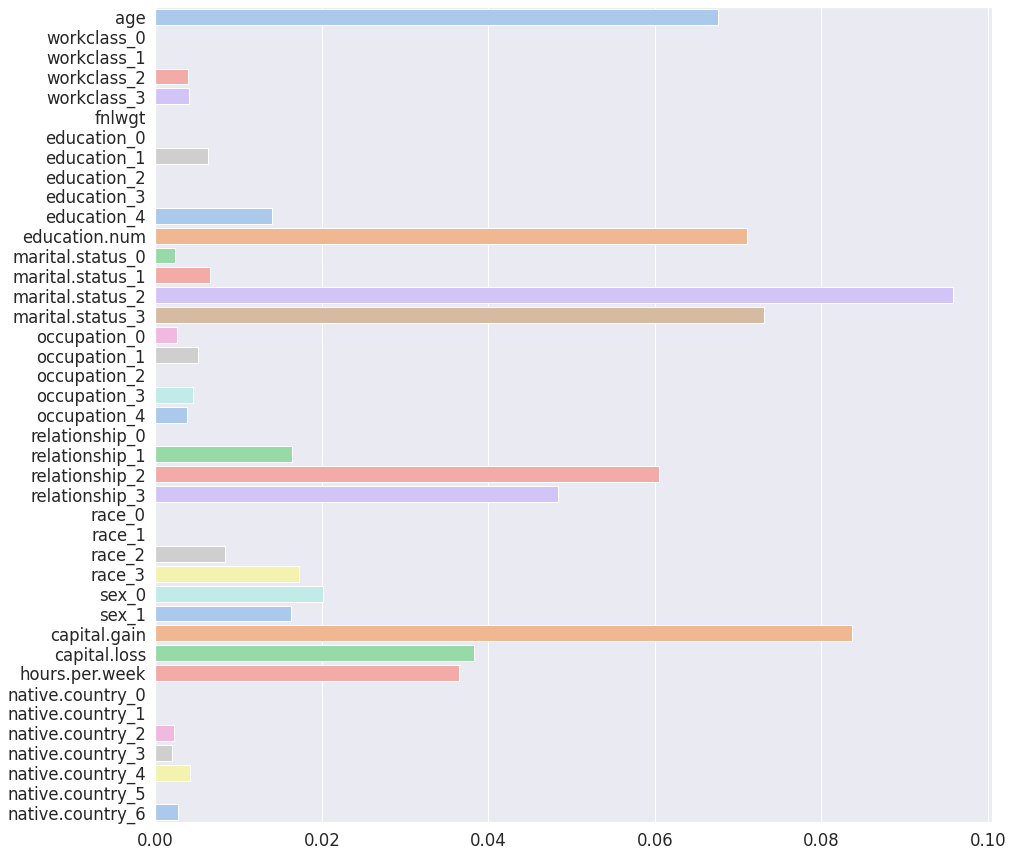

In [56]:
sns.set(font_scale = 1.5)
f, ax = plt.subplots(figsize=(15, 15))
sns.barplot(y = X_train_binary.columns, x = select_k_best_classifier.scores_, palette = 'pastel', orient = 'h');

In [57]:
X_train_mutual_info.head()

,age,education.num,marital.status_2,marital.status_3,relationship_2,relationship_3,sex_0,capital.gain,capital.loss,hours.per.week
0,46,9,0,1,0,1,0,0,0,60
1,66,6,0,1,0,1,0,0,0,40
2,26,9,1,0,1,0,1,0,0,25
3,49,9,0,1,0,1,0,0,0,48
4,17,7,1,0,1,1,0,0,0,15


In [58]:
X_val_mutual_info = select_k_best_classifier.transform(X_val_binary)
X_val_mutual_info = pd.DataFrame(X_val_mutual_info, columns = list(X_val_binary.columns[select_k_best_classifier.get_support()]))

In [59]:
%%time
mutual_info_logit_score = get_score(logit, X_train_mutual_info, y_train, X_val_mutual_info, y_val)
print('Logistic Regression score:', mutual_info_logit_score)

Logistic Regression score: 0.8348437257365388
CPU times: user 292 ms, sys: 185 ms, total: 477 ms
Wall time: 250 ms


In [60]:
%%time
mutual_info_rf_score = get_score(rf, X_train_mutual_info, y_train, X_val_mutual_info, y_val)
print('Random Forest score:', mutual_info_rf_score)

Random Forest score: 0.8817447706678905
CPU times: user 944 ms, sys: 3.58 ms, total: 948 ms
Wall time: 951 ms


### Test chi-squared statistic

In [73]:
select_k_best_classifier = SelectKBest(chi2, 10)

In [74]:
X_train_chi2 = select_k_best_classifier.fit_transform(X_train_binary, y_train)
X_train_chi2 = pd.DataFrame(X_train_chi2, columns = list(X_train_binary.columns[select_k_best_classifier.get_support()]))

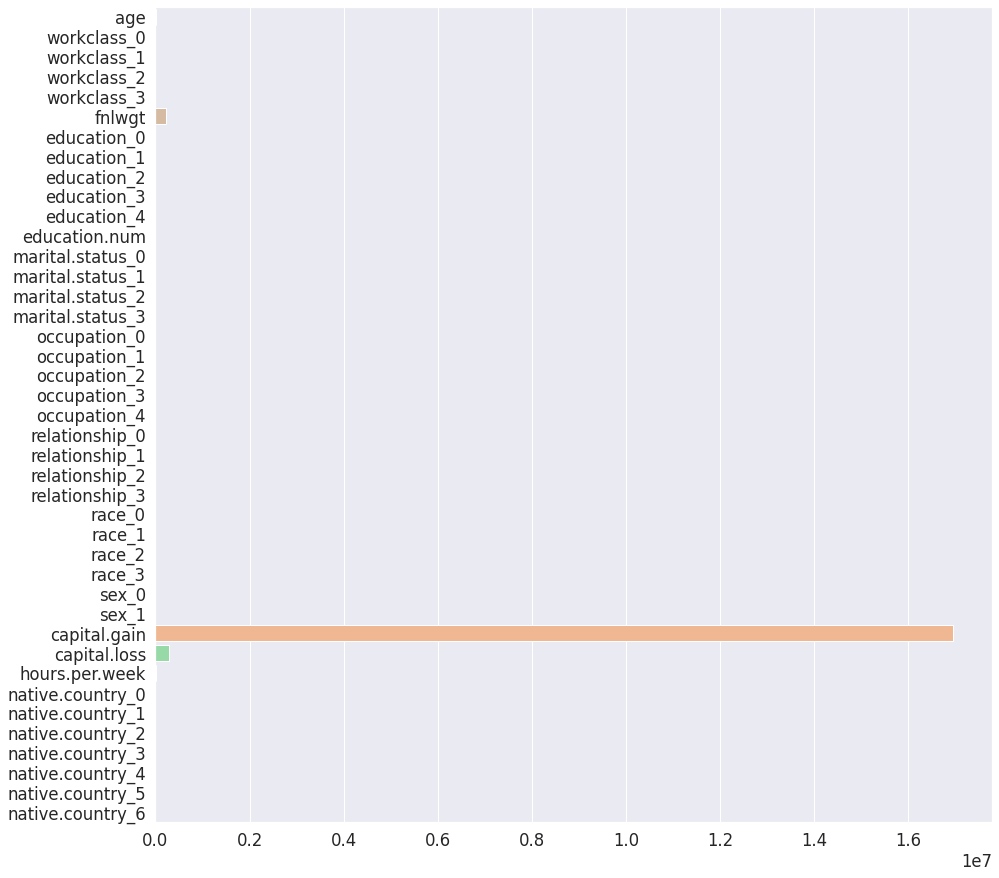

In [75]:
sns.set(font_scale = 1.5)
f, ax = plt.subplots(figsize=(15, 15))
sns.barplot(y = X_train_binary.columns, x = select_k_best_classifier.scores_, palette = 'pastel', orient = 'h');

In [76]:
X_train_chi2.head()

,age,fnlwgt,education.num,marital.status_2,marital.status_3,relationship_2,relationship_3,capital.gain,capital.loss,hours.per.week
0,46,456956,9,0,1,0,1,0,0,60
1,66,263637,6,0,1,0,1,0,0,40
2,26,138597,9,1,0,1,0,0,0,25
3,49,165152,9,0,1,0,1,0,0,48
4,17,193748,7,1,0,1,1,0,0,15


In [77]:
X_val_chi2 = select_k_best_classifier.transform(X_val_binary)
X_val_chi2 = pd.DataFrame(X_val_chi2, columns = list(X_val_binary.columns[select_k_best_classifier.get_support()]))

In [78]:
%%time
chi2_logit_score = get_score(logit, X_train_chi2, y_train, X_val_chi2, y_val)
print('Logistic Regression score:', chi2_logit_score)

Logistic Regression score: 0.5836650656329045
CPU times: user 211 ms, sys: 146 ms, total: 357 ms
Wall time: 190 ms


In [79]:
%%time
chi2_rf_score = get_score(rf, X_train_chi2, y_train, X_val_chi2, y_val)
print('Random Forest score:', chi2_rf_score)

Random Forest score: 0.8885079847907275
CPU times: user 1.08 s, sys: 4.11 ms, total: 1.09 s
Wall time: 1.09 s


### ANOVA F-value

In [ ]:
select_k_best_classifier = SelectKBest(f_classif, 10)

In [ ]:
X_train_f = select_k_best_classifier.fit_transform(X_train_binary, y_train)
X_train_f = pd.DataFrame(X_train_f, columns = list(X_train_binary.columns[select_k_best_classifier.get_support()]))

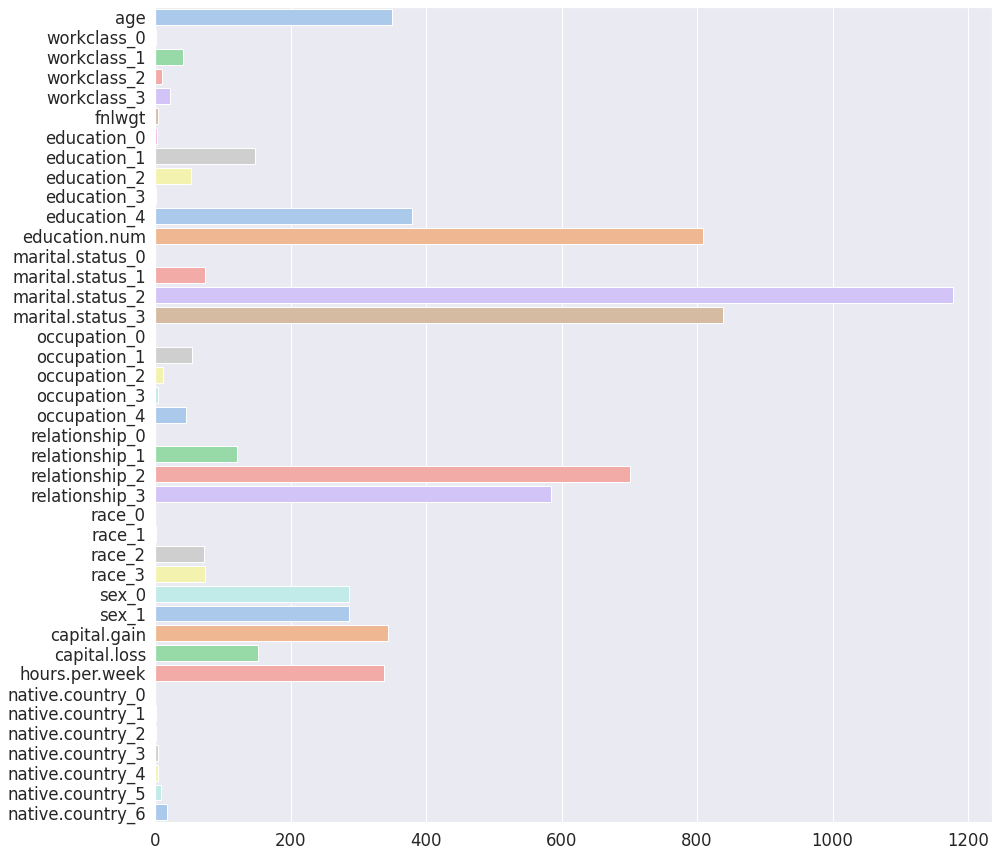

In [ ]:
sns.set(font_scale = 1.5)
f, ax = plt.subplots(figsize=(15, 15))
sns.barplot(y = X_train_binary.columns, x = select_k_best_classifier.scores_, palette = 'pastel', orient = 'h');

In [ ]:
X_train_f.head()

,age,education_4,education.num,marital.status_2,marital.status_3,relationship_2,relationship_3,sex_1,capital.gain,hours.per.week
0,46,1,9,0,1,0,1,1,0,60
1,66,0,6,0,1,0,1,1,0,40
2,26,1,9,1,0,1,0,0,0,25
3,49,1,9,0,1,0,1,1,0,48
4,17,1,7,1,0,1,1,1,0,15


In [ ]:
X_val_f = select_k_best_classifier.transform(X_val_binary)
X_val_f = pd.DataFrame(X_val_f, columns = list(X_val_binary.columns[select_k_best_classifier.get_support()]))

In [ ]:
%%time
f_score_logit_score = get_score(logit, X_train_f, y_train, X_val_f, y_val)
print('Logistic Regression score:', f_score_logit_score)

Logistic Regression score: 0.8640033277861097
CPU times: user 288 ms, sys: 181 ms, total: 469 ms
Wall time: 256 ms


In [ ]:
%%time
f_score_rf_score = get_score(rf, X_train_f, y_train, X_val_f, y_val)
print('Random Forest score:', f_score_rf_score)

Random Forest score: 0.8703284373054085
CPU times: user 967 ms, sys: 8.74 ms, total: 975 ms
Wall time: 965 ms


##Сложный вариант

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score

In [ ]:
model = RandomForestClassifier(n_estimators = 100, criterion = "entropy")

In [ ]:
y_train_kf = y_train.copy()
y_train_kf[y_train_kf == '<=50K'] = 0
y_train_kf[y_train_kf == '>50K'] = 1
y_train_kf = y_train_kf.astype('int')

In [ ]:
%%time

res_f1 = []
for i in range(2, 25, 1):
  print(i)
  select_k_best_classifier = SelectKBest(mutual_info_classif, k = i)
  X_new = select_k_best_classifier.fit_transform(X_train_binary, y_train_kf)
  X_new = pd.DataFrame(X_new)

  skf = KFold(n_splits = 5)
  f1 = []
  for train_index, test_index in skf.split(y_train_kf):
    X_t = X_new.iloc[train_index]
    X_v = X_new.iloc[test_index]
    y_t = y_train_kf[train_index]
    y_v = y_train_kf[test_index]

    model.fit(X_t, y_t)
    preds = model.predict(X_t)
    f1.append(f1_score(y_t, preds))

  res_f1.append(np.mean(f1))

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
CPU times: user 1min 49s, sys: 121 ms, total: 1min 49s
Wall time: 1min 50s


In [ ]:
feature_f1 = pd.DataFrame({'count_feature': list(range(2, 25, 1)), 'f1': res_f1})

In [ ]:
feature_f1

,count_feature,f1
0,2,0.345023
1,3,0.476783
2,4,0.345245
3,5,0.637458
4,6,0.745579
5,7,0.750534
6,8,0.770186
7,9,0.882639
8,10,0.897294
9,11,0.897533


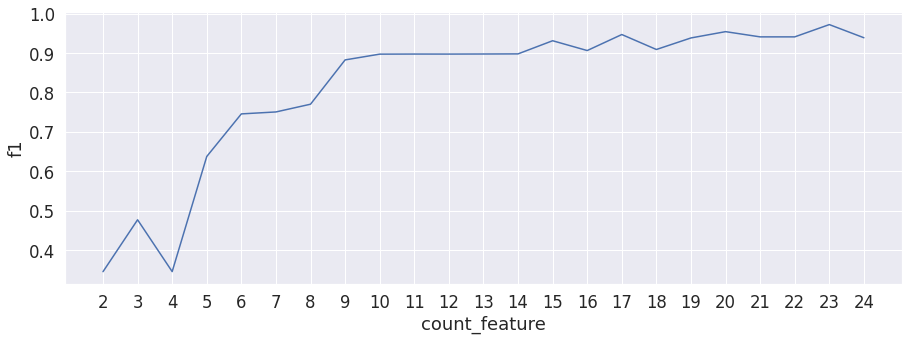

In [ ]:
sns.set(font_scale = 1.5)
f, ax = plt.subplots(figsize=(15, 5))
ax.set_xticks(range(2, 25, 1))
sns.lineplot(data = feature_f1, x = "count_feature", y = "f1");

In [ ]:
select_k_best_classifier = SelectKBest(mutual_info_classif, 13)

In [ ]:
X_train_mutual_info = select_k_best_classifier.fit_transform(X_train_binary, y_train)
X_train_mutual_info = pd.DataFrame(X_train_mutual_info, columns = list(X_train_binary.columns[select_k_best_classifier.get_support()]))

X_val_mutual_info = select_k_best_classifier.transform(X_val_binary)
X_val_mutual_info = pd.DataFrame(X_val_mutual_info, columns = list(X_val_binary.columns[select_k_best_classifier.get_support()]))

In [ ]:
X_train_mutual_info.head()

,age,education_4,education.num,marital.status_2,marital.status_3,relationship_0,relationship_2,relationship_3,sex_0,sex_1,capital.gain,capital.loss,hours.per.week
0,46,1,9,0,1,0,0,1,0,1,0,0,60
1,66,0,6,0,1,0,0,1,0,1,0,0,40
2,26,1,9,1,0,0,1,0,1,0,0,0,25
3,49,1,9,0,1,0,0,1,0,1,0,0,48
4,17,1,7,1,0,0,1,1,0,1,0,0,15


In [ ]:
%%time
mutual_info_iter_logit_score = get_score(logit, X_train_mutual_info, y_train, X_val_mutual_info, y_val)
print('Logistic Regression score:', mutual_info_iter_logit_score)

Logistic Regression score: 0.8535936822074055
CPU times: user 298 ms, sys: 197 ms, total: 495 ms
Wall time: 283 ms


In [ ]:
%%time
mutual_info_iter_rf_score = get_score(rf, X_train_mutual_info, y_train, X_val_mutual_info, y_val)
print('Random Forest score:', mutual_info_iter_rf_score)

Random Forest score: 0.8797155029362497
CPU times: user 929 ms, sys: 6.96 ms, total: 936 ms
Wall time: 940 ms


# Wrapper methods

## Генетический алгоритм

In [ ]:
pip install pyeasyga

  Created wheel for pyeasyga: filename=pyeasyga-0.3.1-py2.py3-none-any.whl size=6777 sha256=6374aaae6f804ee87b085c30074a1d778d4f4fa23ed72251b11f7df6e77d78dd
  Stored in directory: /root/.cache/pip/wheels/ef/cf/ef/7aff9fcd6c1e59dc276182f29a32e7c197665dd5eb547f30e6
Successfully built pyeasyga


In [ ]:
from pyeasyga import pyeasyga
from math import sqrt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score

In [ ]:
vector = [i for i in range(X_train_binary.shape[1])]
X_fitness = X_train_binary.copy()
y_fitness = y_train.copy()

y_fitness[y_fitness == '<=50K'] = 0
y_fitness[y_fitness == '>50K'] = 1

y_fitness = y_fitness.astype('int')

In [ ]:
def fitness(individual, vector):
  if(sum(individual) < 1):
    return(0)
  
  mask = np.array(individual).astype(bool)
  model = RandomForestClassifier(n_estimators = 50, criterion = "entropy")

  global X_fitness, y_fitness
  X_fitness_pop = X_fitness[X_fitness.columns[mask]]

  skf = KFold(n_splits = 5)
  f1 = []
  for train_index, test_index in skf.split(y_fitness):
    X_t = X_fitness_pop.iloc[train_index]
    X_v = X_fitness_pop.iloc[test_index]
    y_t = y_fitness[train_index]
    y_v = y_fitness[test_index]

    model.fit(X_t, y_t)
    preds = model.predict(X_v)
    f1.append(f1_score(y_v, preds))

  return(np.mean(f1) / sqrt(sum(individual)))

In [ ]:
ga = pyeasyga.GeneticAlgorithm(vector, generations = 10)        # initialise the GA with data
ga.population_size = 10
ga.fitness_function = fitness

In [ ]:
%%time
ga.run()

CPU times: user 2min 44s, sys: 246 ms, total: 2min 44s
Wall time: 2min 44s


In [ ]:
mask = list(map(bool, ga.best_individual()[1]))

In [ ]:
X_train_ga = X_train_binary[X_train_binary.columns[mask]]
X_val_ga = X_val_binary[X_val_binary.columns[mask]]

In [ ]:
X_train_ga.head()

,age,workclass_3,fnlwgt,education_3,education.num,marital.status_2,marital.status_3,occupation_0,occupation_2,relationship_2,sex_0,capital.gain,capital.loss,native.country_1,native.country_2,native.country_4
0,46,1,456956,0,9,0,1,0,0,0,0,0,0,0,0,0
1,66,0,263637,1,6,0,1,0,0,0,0,0,0,0,0,0
2,26,1,138597,0,9,1,0,0,0,1,1,0,0,0,0,0
3,49,0,165152,0,9,0,1,0,1,0,0,0,0,0,0,0
4,17,0,193748,1,7,1,0,0,1,1,0,0,0,0,0,0


In [ ]:
%%time
ga_logit_score = get_score(logit, X_train_ga, y_train, X_val_ga, y_val)
print('Logistic Regression score:', ga_logit_score)

Logistic Regression score: 0.5941578276731273
CPU times: user 221 ms, sys: 156 ms, total: 378 ms
Wall time: 200 ms


In [ ]:
%%time
ga_rf_score = get_score(rf, X_train_ga, y_train, X_val_ga, y_val)
print('Random Forest score:', ga_rf_score)

Random Forest score: 0.8809458740379095
CPU times: user 1.12 s, sys: 15 ms, total: 1.13 s
Wall time: 1.13 s


## Boruta

In [ ]:
!pip install boruta

     |████████████████████████████████| 61kB 3.1MB/s 


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy

In [ ]:
rf = RandomForestClassifier(n_jobs = -1, class_weight = 'balanced', n_estimators = 100)
boruta_feature_selector = BorutaPy(rf, n_estimators = 'auto', verbose = 1, random_state = 42, max_iter = 10, perc = 90)

In [ ]:
boruta_feature_selector.fit(np.array(X_train_binary), y_train)

Iteration: 1 / 10
Iteration: 2 / 10
Iteration: 3 / 10
Iteration: 4 / 10
Iteration: 5 / 10
Iteration: 6 / 10
Iteration: 7 / 10
Iteration: 8 / 10
Iteration: 9 / 10


BorutaPy finished running.

Iteration: 	10 / 10
Confirmed: 	14
Tentative: 	2
Rejected: 	22


BorutaPy(alpha=0.05,
         estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                          class_weight='balanced',
                                          criterion='gini', max_depth=None,
                                          max_features='auto',
                                          max_leaf_nodes=None, max_samples=None,
                                          min_impurity_decrease=0.0,
                                          min_impurity_split=None,
                                          min_samples_leaf=1,
                                          min_samples_split=2,
                                          min_weight_fraction_leaf=0.0,
                                          n_estimators=61, n_jobs=-1,
                                          oob_score=False,
                                          random_state=RandomState(MT19937) at 0x7FC9D49B9048,
                                          verbose=0, warm_star

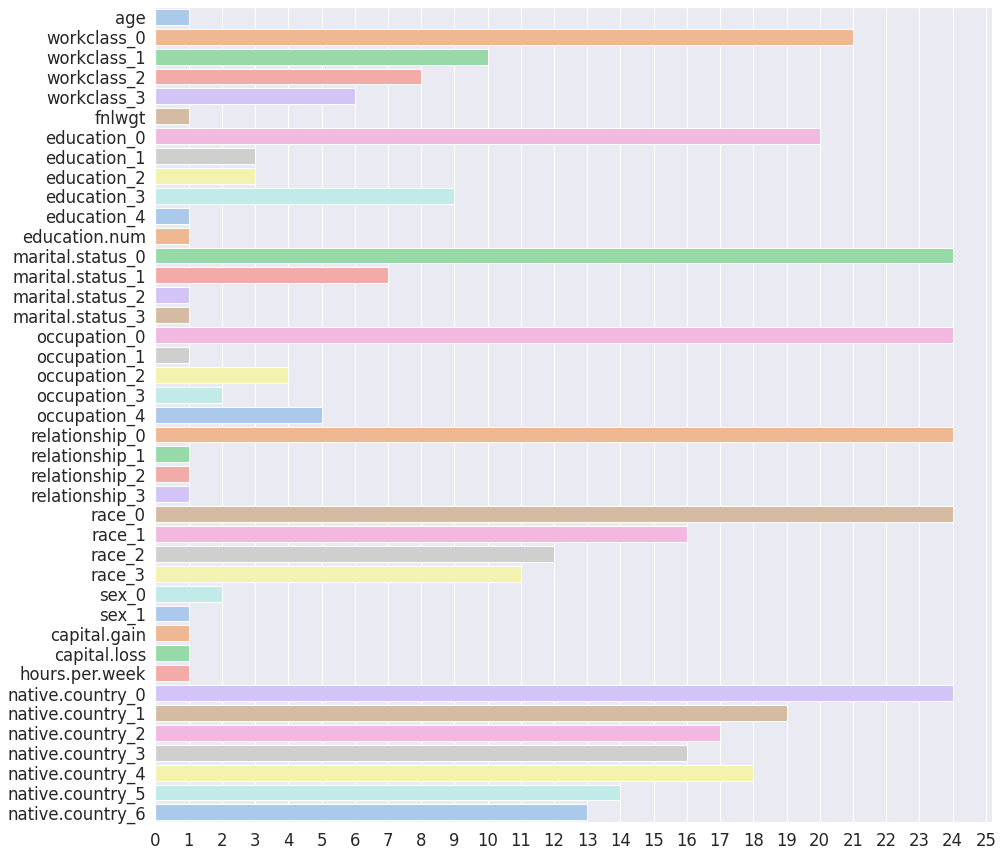

In [ ]:
sns.set(font_scale = 1.5)
f, ax = plt.subplots(figsize=(15, 15))
ax.set_xticks(range(0, 26, 1))
sns.barplot(y = X_train_binary.columns, x = boruta_feature_selector.ranking_, palette = 'pastel', orient = 'h');

In [ ]:
X_train_boruta = X_train_binary[X_train_binary.columns[boruta_feature_selector.support_]]
X_val_boruta = X_val_binary[X_train_binary.columns[boruta_feature_selector.support_]]

In [ ]:
X_train_boruta.head()

,age,fnlwgt,education_4,education.num,marital.status_2,marital.status_3,occupation_1,relationship_1,relationship_2,relationship_3,sex_1,capital.gain,capital.loss,hours.per.week
0,46,456956,1,9,0,1,0,0,0,1,1,0,0,60
1,66,263637,0,6,0,1,0,0,0,1,1,0,0,40
2,26,138597,1,9,1,0,0,0,1,0,0,0,0,25
3,49,165152,1,9,0,1,0,0,0,1,1,0,0,48
4,17,193748,1,7,1,0,0,0,1,1,1,0,0,15


In [ ]:
%%time
boruta_logit_score = get_score(logit, X_train_boruta, y_train, X_val_boruta, y_val)
print('Logistic Regression score:', boruta_logit_score)

Logistic Regression score: 0.5835869429302755
CPU times: user 226 ms, sys: 145 ms, total: 371 ms
Wall time: 200 ms


In [ ]:
%%time
boruta_rf_score = get_score(rf, X_train_boruta, y_train, X_val_boruta, y_val)
print('Random Forest score:', boruta_rf_score)

Random Forest score: 0.8897566461892727
CPU times: user 943 ms, sys: 40.1 ms, total: 983 ms
Wall time: 702 ms


#Embedded methods

In [ ]:
from sklearn.feature_selection import SelectFromModel

##L1-based feature selection

###Logistic/Lasso Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
lr = LogisticRegression(C = 0.01).fit(X_train_binary, y_train)

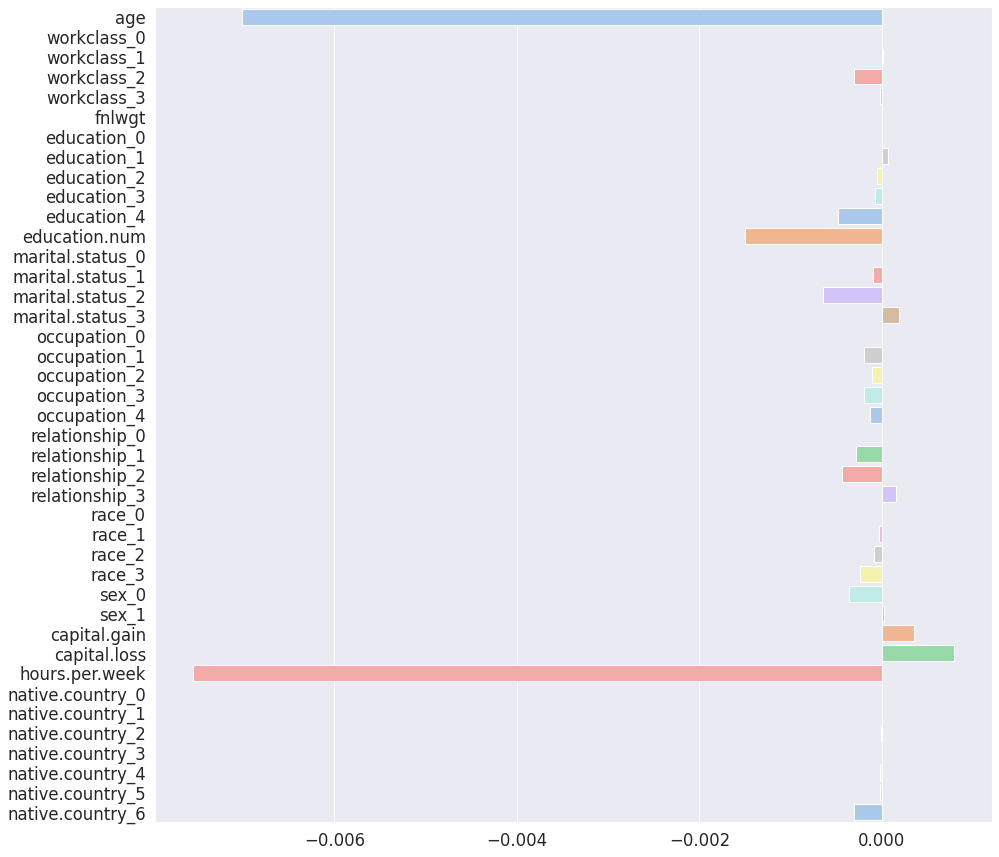

In [ ]:
sns.set(font_scale = 1.5)
f, ax = plt.subplots(figsize=(15, 15))
sns.barplot(y = X_train_binary.columns, x = lr.coef_[0], palette = 'pastel', orient = 'h');

In [ ]:
model = SelectFromModel(lr, prefit = True)

In [ ]:
X_train_lr = model.transform(X_train_binary)
X_val_lr = model.transform(X_val_binary)

In [ ]:
X_train_lr = pd.DataFrame(X_train_lr, columns = list(X_train_binary.columns[model.get_support()]))
X_val_lr = pd.DataFrame(X_val_lr, columns = list(X_val_binary.columns[model.get_support()]))

In [ ]:
X_train_lr.head()

,age,education.num,marital.status_2,capital.loss,hours.per.week
0,46,9,0,0,60
1,66,6,0,0,40
2,26,9,1,0,25
3,49,9,0,0,48
4,17,7,1,0,15


In [ ]:
%%time
log_reg_logit_score = get_score(logit, X_train_lr, y_train, X_val_lr, y_val)
print('Logistic Regression score:', log_reg_logit_score)

Logistic Regression score: 0.8631008439105903
CPU times: user 236 ms, sys: 142 ms, total: 379 ms
Wall time: 229 ms


In [ ]:
%%time
log_reg_rf_score = get_score(rf, X_train_lr, y_train, X_val_lr, y_val)
print('Random Forest score:', log_reg_rf_score)

Random Forest score: 0.8295243165345704
CPU times: user 830 ms, sys: 28.2 ms, total: 859 ms
Wall time: 599 ms


###Linear SVM

In [ ]:
from sklearn.svm import LinearSVC

In [ ]:
lsvc = LinearSVC(C = 0.01, penalty = "l1", dual = False).fit(X_train_binary, y_train)

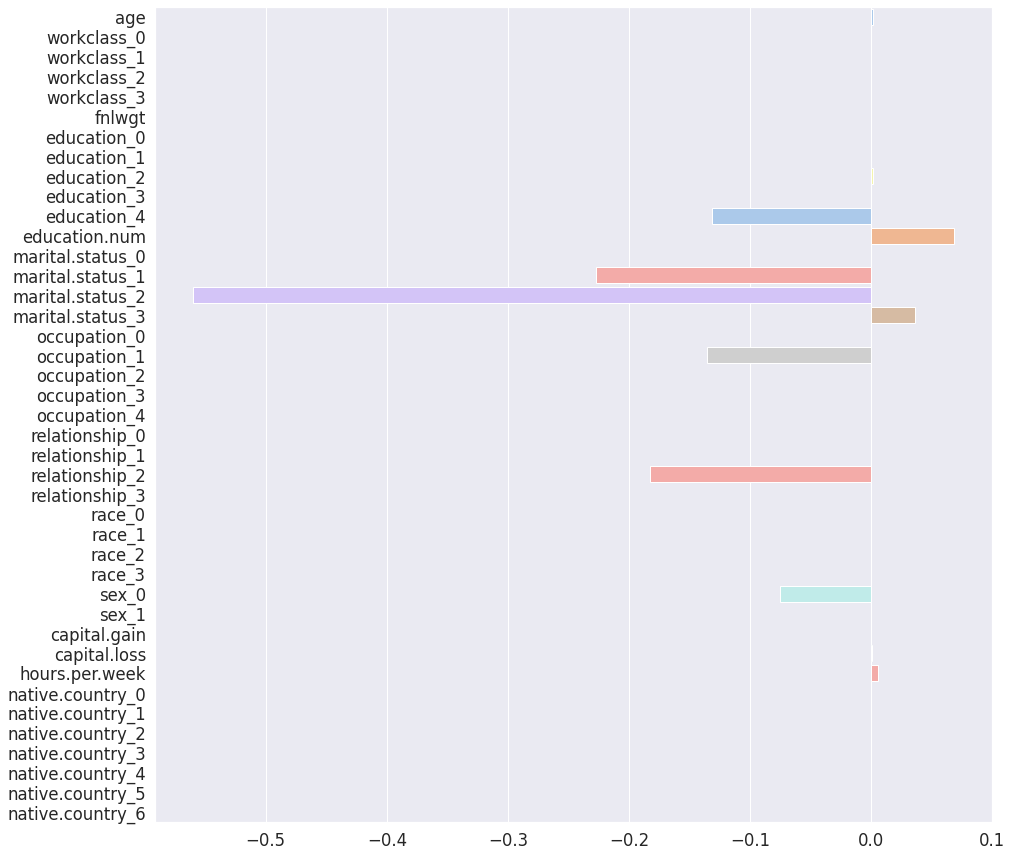

In [ ]:
sns.set(font_scale = 1.5)
f, ax = plt.subplots(figsize=(15, 15))
sns.barplot(y = X_train_binary.columns, x = lsvc.coef_[0], palette = 'pastel', orient = 'h');

In [ ]:
model = SelectFromModel(lsvc, prefit = True)

In [ ]:
X_train_lsvc = model.transform(X_train_binary)
X_val_lsvc = model.transform(X_val_binary)

In [ ]:
X_train_lsvc = pd.DataFrame(X_train_lsvc, columns = list(X_train_binary.columns[model.get_support()]))
X_val_lsvc = pd.DataFrame(X_val_lsvc, columns = list(X_val_binary.columns[model.get_support()]))

In [ ]:
X_train_lsvc.head()

,age,education_2,education_4,education.num,marital.status_1,marital.status_2,marital.status_3,occupation_1,relationship_2,sex_0,capital.gain,capital.loss,hours.per.week
0,46,0,1,9,0,0,1,0,0,0,0,0,60
1,66,0,0,6,0,0,1,0,0,0,0,0,40
2,26,0,1,9,0,1,0,0,1,1,0,0,25
3,49,0,1,9,0,0,1,0,0,0,0,0,48
4,17,0,1,7,0,1,0,0,1,0,0,0,15


In [ ]:
%%time
lsvc_logit_score = get_score(logit, X_train_lsvc, y_train, X_val_lsvc, y_val)
print('Logistic Regression score with binary encoding:', be_logit_score)

Logistic Regression score with binary encoding: 0.5836650656329045
CPU times: user 302 ms, sys: 180 ms, total: 482 ms
Wall time: 257 ms


In [ ]:
%%time
lsvc_rf_score = get_score(rf, X_train_lsvc, y_train, X_val_lsvc, y_val)
print('Random Forest score:', lsvc_rf_score)

Random Forest score: 0.875534771522996
CPU times: user 866 ms, sys: 28.2 ms, total: 894 ms
Wall time: 600 ms


##Tree-based feature selection

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
model_rf = RandomForestClassifier().fit(X_train_binary, y_train)

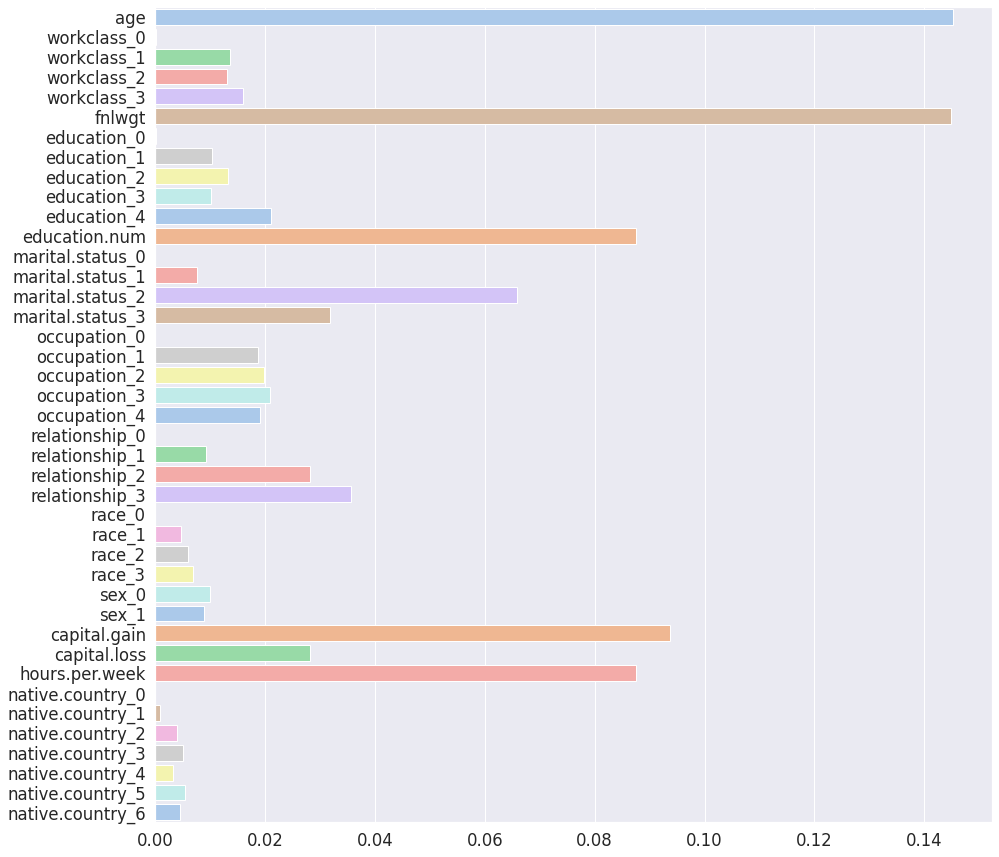

In [ ]:
sns.set(font_scale = 1.5)
f, ax = plt.subplots(figsize=(15, 15))
sns.barplot(y = X_train_binary.columns, x = model_rf.feature_importances_, palette = 'pastel', orient = 'h');

In [ ]:
model = SelectFromModel(model_rf, prefit = True)

In [ ]:
X_train_rf = model.transform(X_train_binary)
X_val_rf = model.transform(X_val_binary)

In [ ]:
X_train_rf = pd.DataFrame(X_train_rf, columns = list(X_train_binary.columns[model.get_support()]))
X_val_rf = pd.DataFrame(X_val_rf, columns = list(X_val_binary.columns[model.get_support()]))

In [ ]:
X_train_rf.head()

,age,fnlwgt,education.num,marital.status_2,marital.status_3,relationship_2,relationship_3,capital.gain,capital.loss,hours.per.week
0,46,456956,9,0,1,0,1,0,0,60
1,66,263637,6,0,1,0,1,0,0,40
2,26,138597,9,1,0,1,0,0,0,25
3,49,165152,9,0,1,0,1,0,0,48
4,17,193748,7,1,0,1,1,0,0,15


In [ ]:
%%time
rf_logit_score = get_score(logit, X_train_rf, y_train, X_val_rf, y_val)
print('Logistic Regression score:', rf_logit_score)

Logistic Regression score: 0.5836650656329045
CPU times: user 212 ms, sys: 151 ms, total: 364 ms
Wall time: 202 ms


In [ ]:
%%time
rf_rf_score = get_score(rf, X_train_rf, y_train, X_val_rf, y_val)
print('Random Forest score:', rf_rf_score)

Random Forest score: 0.8874417507649519
CPU times: user 976 ms, sys: 28.2 ms, total: 1 s
Wall time: 693 ms


#PCA, t-SNE, etc.

##Стандартизируем данные

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
X_train_binary.head()

,age,workclass_0,workclass_1,workclass_2,workclass_3,fnlwgt,education_0,education_1,education_2,education_3,education_4,education.num,marital.status_0,marital.status_1,marital.status_2,marital.status_3,occupation_0,occupation_1,occupation_2,occupation_3,occupation_4,relationship_0,relationship_1,relationship_2,relationship_3,race_0,race_1,race_2,race_3,sex_0,sex_1,capital.gain,capital.loss,hours.per.week,native.country_0,native.country_1,native.country_2,native.country_3,native.country_4,native.country_5,native.country_6
0,46,0,0,0,1,456956,0,0,0,0,1,9,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,60,0,0,0,0,0,0,1
1,66,0,0,1,0,263637,0,0,0,1,0,6,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,40,0,0,0,0,0,0,1
2,26,0,0,1,1,138597,0,0,0,0,1,9,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,1,0,1,0,0,0,25,0,0,0,0,0,0,1
3,49,0,0,1,0,165152,0,0,0,0,1,9,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,48,0,0,0,0,0,0,1
4,17,0,0,1,0,193748,0,0,0,1,1,7,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,1,0,0,15,0,0,0,0,0,0,1


In [ ]:
X_train_binary.describe().T

,count,mean,std,min,25%,50%,75%,max
age,6512.0,38.673833,13.621602,17.0,28.0,37.0,48.00,90.0
workclass_0,6512.0,0.000461,0.021460,0.0,0.0,0.0,0.00,1.0
workclass_1,6512.0,0.120547,0.325625,0.0,0.0,0.0,0.00,1.0
workclass_2,6512.0,0.859797,0.347224,0.0,1.0,1.0,1.00,1.0
workclass_3,6512.0,0.192721,0.394466,0.0,0.0,0.0,0.00,1.0
fnlwgt,6512.0,189027.158784,102792.858429,19302.0,118500.0,178331.5,237650.75,1268339.0
education_0,6512.0,0.001229,0.035031,0.0,0.0,0.0,0.00,1.0
education_1,6512.0,0.165848,0.371972,0.0,0.0,0.0,0.00,1.0
education_2,6512.0,0.487408,0.499880,0.0,0.0,0.0,1.00,1.0
education_3,6512.0,0.194717,0.396013,0.0,0.0,0.0,0.00,1.0


In [ ]:
scaler = StandardScaler() 
scaler.fit(X_train_binary) 
X_train_binary_scale = scaler.transform(X_train_binary)
X_train_binary_scale = pd.DataFrame(X_train_binary_scale, columns = X_train_binary.columns) 

In [ ]:
X_val_binary_scale = scaler.transform(X_val_binary)
X_val_binary_scale = pd.DataFrame(X_val_binary_scale, columns = X_val_binary.columns) 

In [ ]:
X_train_binary_scale.head()

,age,workclass_0,workclass_1,workclass_2,workclass_3,fnlwgt,education_0,education_1,education_2,education_3,education_4,education.num,marital.status_0,marital.status_1,marital.status_2,marital.status_3,occupation_0,occupation_1,occupation_2,occupation_3,occupation_4,relationship_0,relationship_1,relationship_2,relationship_3,race_0,race_1,race_2,race_3,sex_0,sex_1,capital.gain,capital.loss,hours.per.week,native.country_0,native.country_1,native.country_2,native.country_3,native.country_4,native.country_5,native.country_6
0,0.537876,-0.021469,-0.37023,-2.476395,2.046667,2.606693,-0.035072,-0.445894,-0.975125,-0.491732,0.690879,-0.429915,0.0,-0.290257,-0.949083,0.768518,0.0,-0.686275,-0.951424,-1.072327,0.804326,0.0,-0.707921,-0.635414,0.802256,0.0,-0.205962,-0.342305,0.344261,-0.701576,0.701576,-0.143956,-0.21485,1.586622,0.0,-0.060821,-0.184334,-0.208782,-0.195192,-0.248938,0.237967
1,2.006245,-0.021469,-0.37023,0.403813,-0.488599,0.725883,-0.035072,-0.445894,-0.975125,2.033629,-1.447431,-1.603264,0.0,-0.290257,-0.949083,0.768518,0.0,-0.686275,-0.951424,0.932552,-1.243277,0.0,-0.707921,-0.635414,0.802256,0.0,-0.205962,-0.342305,0.344261,-0.701576,0.701576,-0.143956,-0.21485,-0.052441,0.0,-0.060821,-0.184334,-0.208782,-0.195192,-0.248938,0.237967
2,-0.930493,-0.021469,-0.37023,0.403813,2.046667,-0.490638,-0.035072,-0.445894,-0.975125,-0.491732,0.690879,-0.429915,0.0,-0.290257,1.053648,-1.301205,0.0,-0.686275,-0.951424,0.932552,0.804326,0.0,-0.707921,1.573777,-1.246485,0.0,-0.205962,2.921371,-2.904769,1.425362,-1.425362,-0.143956,-0.21485,-1.281739,0.0,-0.060821,-0.184334,-0.208782,-0.195192,-0.248938,0.237967
3,0.758131,-0.021469,-0.37023,0.403813,-0.488599,-0.232283,-0.035072,-0.445894,-0.975125,-0.491732,0.690879,-0.429915,0.0,-0.290257,-0.949083,0.768518,0.0,-0.686275,1.051056,-1.072327,-1.243277,0.0,-0.707921,-0.635414,0.802256,0.0,-0.205962,-0.342305,0.344261,-0.701576,0.701576,-0.143956,-0.21485,0.603184,0.0,-0.060821,-0.184334,-0.208782,-0.195192,-0.248938,0.237967
4,-1.591259,-0.021469,-0.37023,0.403813,-0.488599,0.045929,-0.035072,-0.445894,-0.975125,2.033629,0.690879,-1.212148,0.0,-0.290257,1.053648,-1.301205,0.0,-0.686275,1.051056,-1.072327,-1.243277,0.0,-0.707921,1.573777,0.802256,0.0,-0.205962,-0.342305,0.344261,-0.701576,0.701576,-0.143956,-0.21485,-2.101270,0.0,-0.060821,-0.184334,-0.208782,-0.195192,-0.248938,0.237967


In [ ]:
X_train_binary_scale.describe().T

,count,mean,std,min,25%,50%,75%,max
age,6512.0,-3.614959e-16,1.000077,-1.591259,-0.783656,-0.122890,0.684713,3.768287
workclass_0,6512.0,5.899072e-16,1.000077,-0.021469,-0.021469,-0.021469,-0.021469,46.579681
workclass_1,6512.0,1.975624e-16,1.000077,-0.370230,-0.370230,-0.370230,-0.370230,2.701026
workclass_2,6512.0,4.750329e-16,1.000077,-2.476395,0.403813,0.403813,0.403813,0.403813
workclass_3,6512.0,-1.969316e-16,1.000077,-0.488599,-0.488599,-0.488599,-0.488599,2.046667
fnlwgt,6512.0,-3.605412e-17,1.000077,-1.651264,-0.686162,-0.104059,0.473061,10.500678
education_0,6512.0,6.556360e-17,1.000077,-0.035072,-0.035072,-0.035072,-0.035072,28.513155
education_1,6512.0,-1.693388e-15,1.000077,-0.445894,-0.445894,-0.445894,-0.445894,2.242684
education_2,6512.0,-3.186777e-16,1.000077,-0.975125,-0.975125,-0.975125,1.025510,1.025510
education_3,6512.0,-4.843587e-17,1.000077,-0.491732,-0.491732,-0.491732,-0.491732,2.033629


##PCA

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
X_train_binary_scale.shape

(6512, 41)

In [ ]:
pca = PCA(n_components = 41) 
pca.fit(X_train_binary_scale)

PCA(copy=True, iterated_power='auto', n_components=41, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

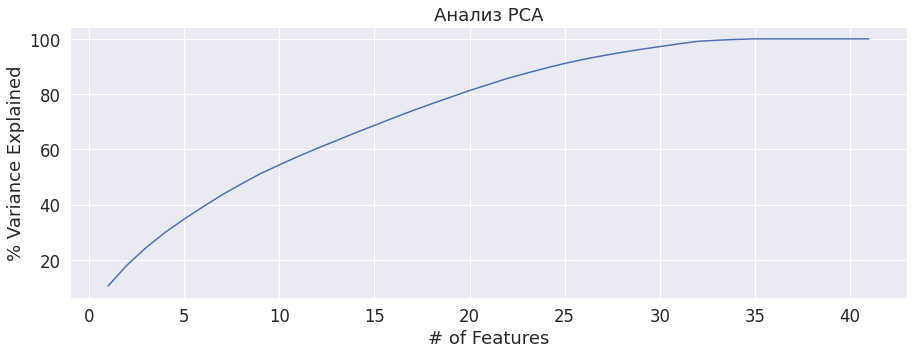

In [ ]:
variance = pca.explained_variance_ratio_
var = np.cumsum (np.round (variance, 3) * 100) 

sns.set(font_scale = 1.5)
f, ax = plt.subplots(figsize=(15, 5))
plt.ylabel('% Variance Explained') 
plt.xlabel('# of Features') 
plt.title('Анализ PCA') 
sns.lineplot(x = range(1, 42), y = var);

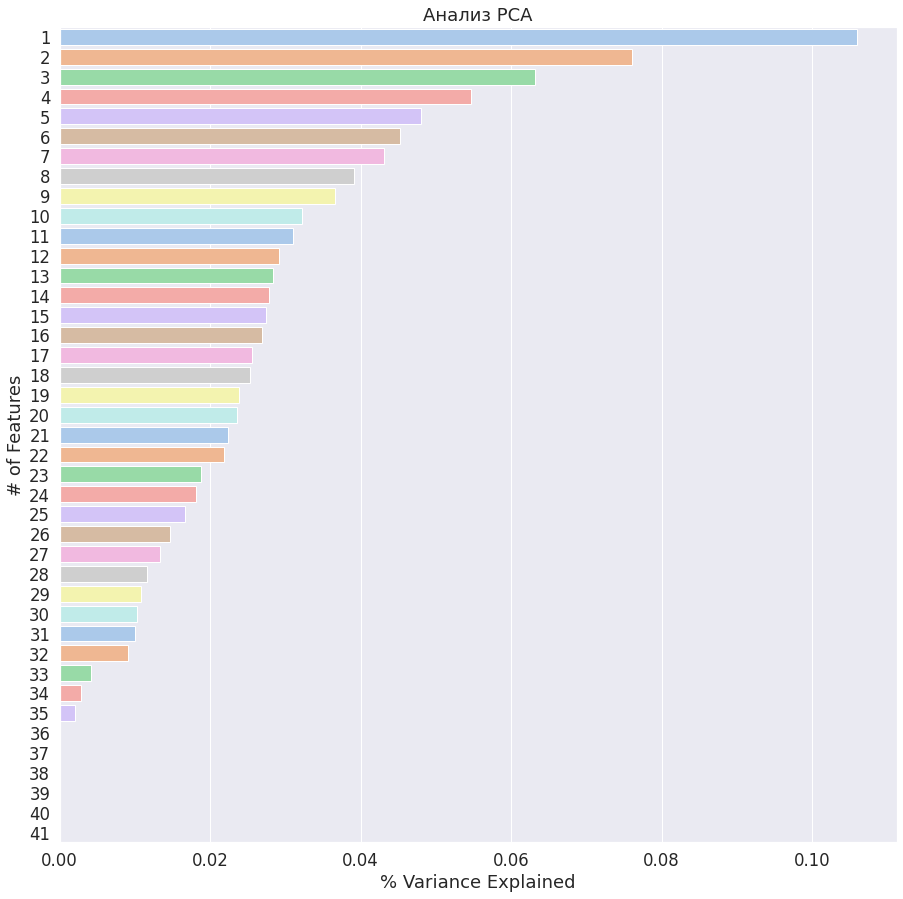

In [ ]:
sns.set(font_scale = 1.5)
f, ax = plt.subplots(figsize=(15, 15))
plt.ylabel('# of Features') 
plt.xlabel('% Variance Explained') 
plt.title('Анализ PCA') 
sns.barplot(y = list(range(1, 42)), x = pca.explained_variance_ratio_, palette = 'pastel', orient = 'h');

In [ ]:
pca = PCA(n_components = 0.99, svd_solver = 'full') 
pca.fit(X_train_binary_scale)

PCA(copy=True, iterated_power='auto', n_components=0.99, random_state=None,
    svd_solver='full', tol=0.0, whiten=False)

In [ ]:
pca.n_components_

32

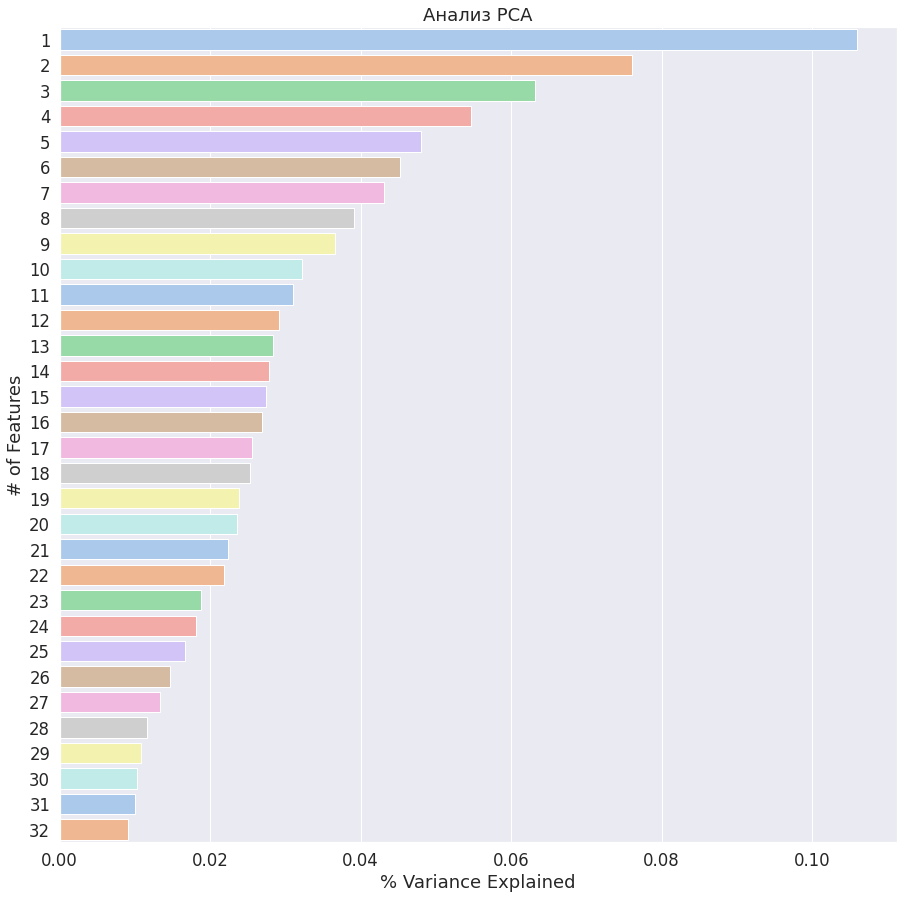

In [ ]:
sns.set(font_scale = 1.5)
f, ax = plt.subplots(figsize=(15, 15))
plt.ylabel('# of Features') 
plt.xlabel('% Variance Explained') 
plt.title('Анализ PCA') 
sns.barplot(y = list(range(1, 33)), x = pca.explained_variance_ratio_, palette = 'pastel', orient = 'h');

In [ ]:
X_train_pca = pca.transform(X_train_binary_scale)
X_val_pca = pca.transform(X_val_binary_scale)

In [ ]:
X_train_pca = pd.DataFrame(X_train_pca, columns = [str(i) + ' component' for i in range(1, pca.n_components_ + 1)])
X_val_pca = pd.DataFrame(X_val_pca, columns = [str(i) + ' component' for i in range(1, pca.n_components_ + 1)])

In [ ]:
X_train_pca.head()

,1 component,2 component,3 component,4 component,5 component,6 component,7 component,8 component,9 component,10 component,11 component,12 component,13 component,14 component,15 component,16 component,17 component,18 component,19 component,20 component,21 component,22 component,23 component,24 component,25 component,26 component,27 component,28 component,29 component,30 component,31 component,32 component
0,-2.589033,-0.354101,-0.067230,1.563200,0.695408,1.298932,0.476003,1.064712,0.594972,1.280008,-0.542175,0.103092,0.441462,0.674454,-1.175777,0.326397,-1.495354,0.304360,0.278470,1.641609,-1.617776,0.607254,-1.715327,0.211253,0.309766,-0.105605,-0.148708,-0.141488,-0.002062,-0.900955,-0.169811,0.812680
1,-2.082808,-0.198884,-0.741868,0.204471,0.725275,-0.936490,-0.229212,-1.409479,0.346573,0.223528,0.189313,-0.255036,-0.188327,0.030138,-0.296968,-0.019603,1.949346,-0.620634,0.438309,0.600908,0.045490,1.185949,0.455666,-0.008453,0.964351,-1.326091,0.200223,0.705252,0.306414,-1.087780,-0.281122,1.944283
2,3.803738,-0.612278,-1.400921,3.066649,-1.588346,1.630625,0.145799,-0.756334,-1.117806,-0.235375,-0.847245,0.468845,0.015431,-0.065585,0.612294,0.679313,-0.750373,0.194172,0.222949,-0.642619,-1.121092,0.322094,0.562237,0.292399,-0.018226,-0.357958,0.378293,1.322422,0.038076,0.170099,0.062645,-0.038728
3,-1.791246,-0.711300,-1.023239,-0.401216,-0.081748,-1.948330,0.546138,0.729645,1.126723,-0.191370,-0.426013,-0.086567,-0.016521,-0.236130,0.274187,0.031918,-0.568839,-0.471105,-0.034521,-0.149939,-0.154401,0.135741,-0.373466,0.103660,0.284520,-0.207057,0.102461,0.183854,-0.032931,-0.540973,-0.120569,0.347531
4,1.158030,-0.692205,-2.375667,-1.728851,-0.760332,0.924763,1.203625,-0.499798,2.480426,-0.369722,-0.196736,-0.491273,-0.759720,-0.028530,0.105748,-0.807344,1.274350,-0.389132,0.947046,-0.775552,-0.208467,0.926376,-0.578686,-0.148265,-0.435074,-0.547424,0.307338,0.429163,-0.479853,-0.282630,-0.037926,0.021401


In [ ]:
%%time
pca_logit_score = get_score(logit, X_train_pca, y_train, X_val_pca, y_val)
print('Logistic Regression score:', pca_logit_score)

Logistic Regression score: 0.895709327699954
CPU times: user 203 ms, sys: 134 ms, total: 337 ms
Wall time: 179 ms


In [ ]:
%%time
pca_rf_score = get_score(rf, X_train_pca, y_train, X_val_pca, y_val)
print('Random Forest score:', pca_rf_score)

Random Forest score: 0.8799837270366089
CPU times: user 2.94 s, sys: 35.9 ms, total: 2.98 s
Wall time: 1.7 s


In [ ]:
pca = PCA(n_components = 2) 
X_train_pca_2_component = pca.fit_transform(X_train_binary_scale)
X_train_pca_2_component = pd.DataFrame(X_train_pca_2_component, columns = [str(i) + ' component' for i in range(1, pca.n_components_ + 1)])

In [ ]:
X_train_pca_2_component["Class"] = y_train

In [ ]:
X_train_pca_2_component.head()

,1 component,2 component,Class
0,-2.588887,-0.355958,<=50K
1,-2.082777,-0.198835,<=50K
2,3.803773,-0.612604,<=50K
3,-1.791197,-0.711852,>50K
4,1.158056,-0.692625,<=50K


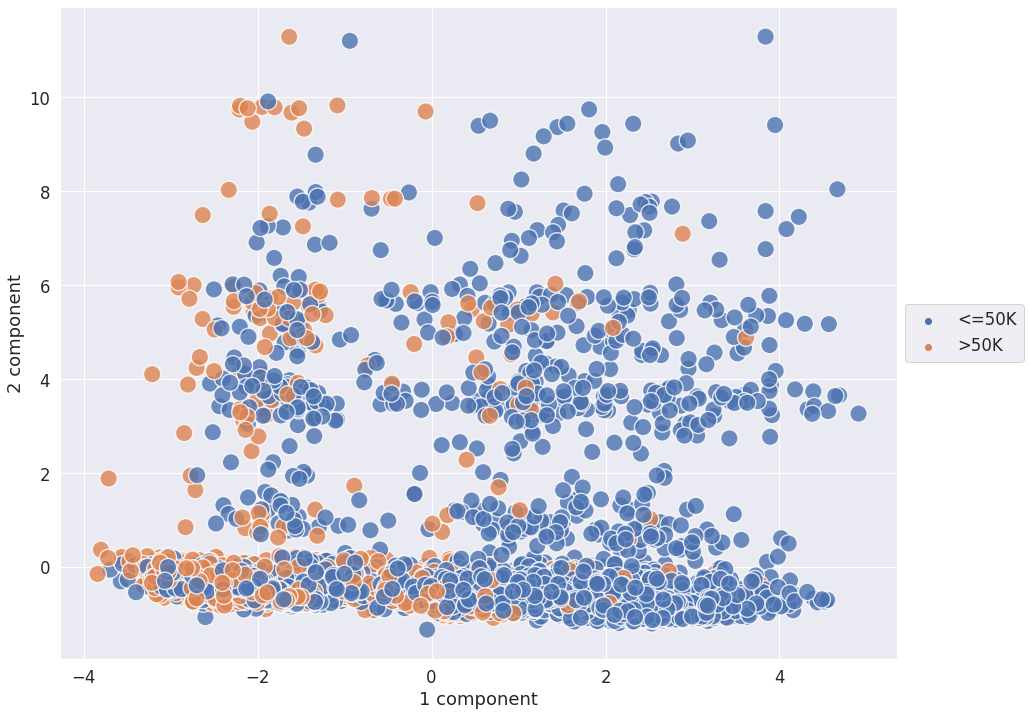

In [ ]:
sns.set(font_scale = 1.5)
f, ax = plt.subplots(figsize=(15, 12))
g = sns.scatterplot(x = "1 component", y = "2 component", hue = "Class", data = X_train_pca_2_component, s = 300, alpha = 0.8)
g.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol = 1)

##t-SNE

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
%%time
X_train_tsne = TSNE(n_components = 2).fit_transform(X_train_binary_scale)

CPU times: user 1min 44s, sys: 304 ms, total: 1min 44s
Wall time: 54.8 s


In [ ]:
X_train_tsne = pd.DataFrame(X_train_tsne)
X_train_tsne.rename(columns = {0:'1-я компонента', 1:'2-я компонента'}, inplace = True)
X_train_tsne["Class"] = y_train
X_train_tsne.head()

,1-я компонента,2-я компонента,Class
0,-11.978951,-10.709542,<=50K
1,-26.345520,-31.685654,<=50K
2,86.849976,-1.014233,<=50K
3,-35.481113,-74.851387,>50K
4,-20.301121,68.114449,<=50K


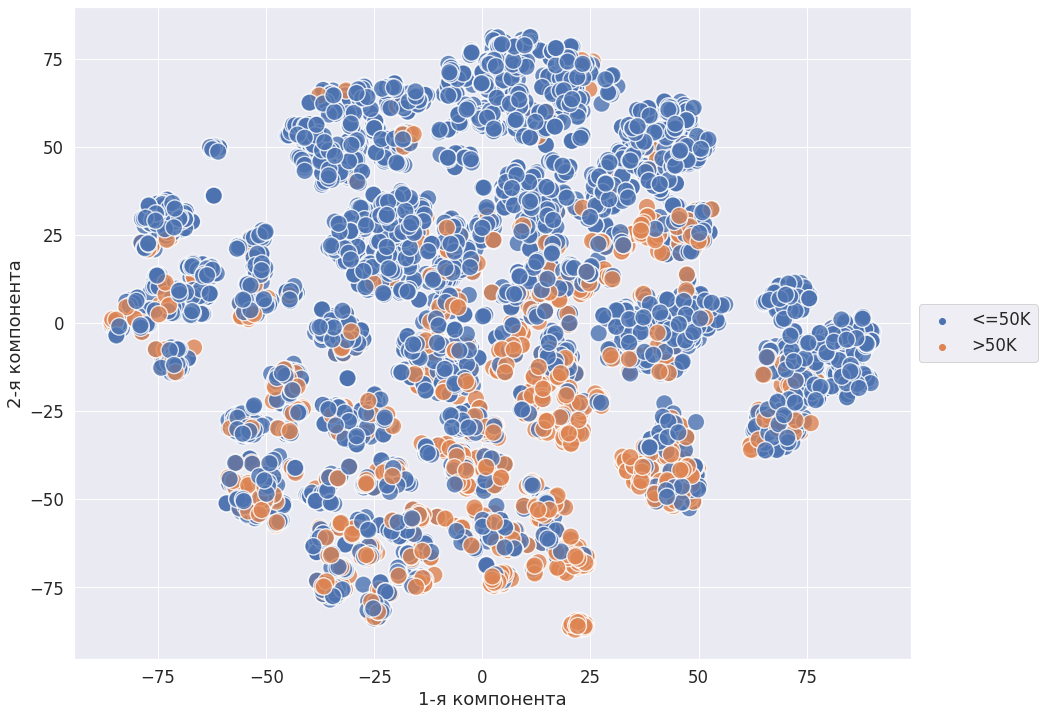

In [ ]:
sns.set(font_scale = 1.5)
f, ax = plt.subplots(figsize=(15, 12))
g = sns.scatterplot(x = "1-я компонента", y = "2-я компонента", hue = "Class", data = X_train_tsne, s = 300, alpha = 0.8)
g.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol = 1)

# Сравним методы

In [ ]:
score_logit = [baseline_logit_score, low_var_logit_score, mutual_info_logit_score, chi2_logit_score, f_score_logit_score, mutual_info_iter_logit_score, 
               ga_logit_score, boruta_logit_score, log_reg_logit_score, lsvc_logit_score, rf_logit_score, pca_logit_score]

score_rf = [baseline_rf_score, low_var_rf_score, mutual_info_logit_score, chi2_rf_score, f_score_rf_score, mutual_info_iter_rf_score, 
            ga_logit_score, boruta_logit_score, log_reg_rf_score, lsvc_rf_score, rf_logit_score, pca_rf_score]

methods = ['Baseline', 'Variance Threshold', 'Mutual information', 'Test chi-squared statistic', 'ANOVA F-value', 'Wrapper mutual information',
           'Genetic algorithm', 'Boruta', 'Model Logistic Regression', 'Model linear SVM', 'Model Random Forest', 'PCA']

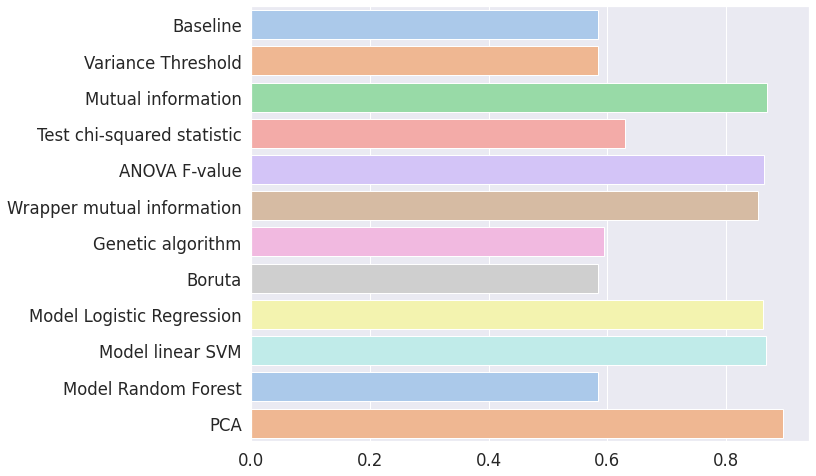

In [ ]:
sns.set(font_scale = 1.5)
f, ax = plt.subplots(figsize=(10, 8))
sns.barplot(y = methods, x = score_logit, palette = 'pastel', orient = 'h');

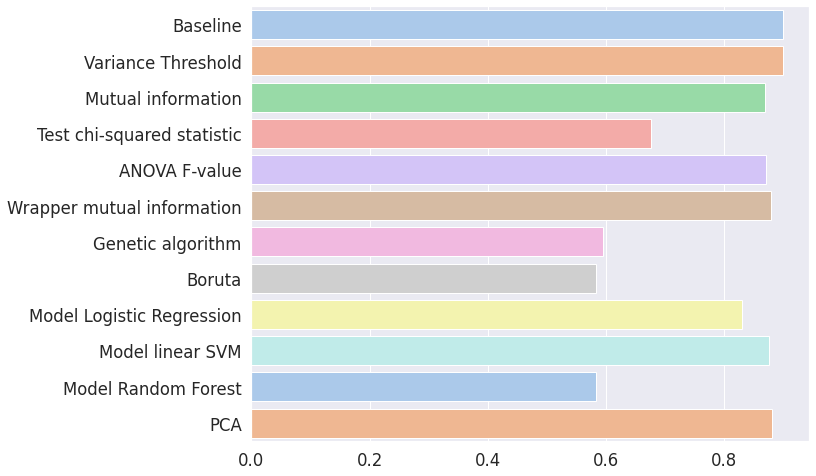

In [ ]:
sns.set(font_scale = 1.5)
f, ax = plt.subplots(figsize=(10, 8))
sns.barplot(y = methods, x = score_rf, palette = 'pastel', orient = 'h');